# Navigation notebook

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

## 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# from unityagents import UnityEnvironment
import os
from mlagents_envs.environment import ActionTuple, BaseEnv
from mlagents_envs.registry import default_registry
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from mlagents_envs.side_channel.environment_parameters_channel import EnvironmentParametersChannel
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid, Grid
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import cv2
from IPython.display import display, HTML
trained = False  # Didn't train yet.

Modifying the EngineConfiguration or EnvironmentParameters is possibile through *side channels*. Increasing the `time_scale` to speed up the training process is very useful.

In [2]:
time_scale = 5  # 20
# capture_frame_rate = 60
# target_frame_rate = 300
eng_channel = EngineConfigurationChannel()
params_channel = EnvironmentParametersChannel()

Next, we will start the environment! There are a few ways to do this
- Run the Environment in Unity. This option provides the most flexibile user interaction and analytics experience. Execute the following cell and then press the "play" button in Unity.
- Run the compiled environment with display output to observe the agent while training.
- Run the headless compiled environment for the fastest training or on a cloud platform.

In [3]:
unity_env = UnityEnvironment(side_channels=[eng_channel, params_channel], seed=42)

Execute the following cell if you want to run a compiled environment. **_Before running the code cell below_**, change the `exefile` parameter to match the location of the Unity environment that you <strike>downloaded</strike> have built.

In [ ]:
import os.path
# exefile = '/home/joerg/repos/deep-reinforcement-learning/p1_navigation/FoodCollectorLinuxHeadless/foodCollectorHeadless.x86_64'
exefile = '/home/joerg/repos/deep-reinforcement-learning/p1_navigation/RayFoodCollectorLinuxHeadless/foodCollector.x86_64'
if os.path.isfile(exefile):
    # env = UnityEnvironment(file_name="...")
    unity_env = UnityEnvironment(
        file_name=exefile,
        side_channels=[eng_channel, params_channel], seed=42)
else:
    print("File doesn't exist. Cannot start environment")

Apply the side channel configuration.

In [4]:
engine_config = {
                 "time_scale": time_scale,
                 #"capture_frame_rate": capture_frame_rate,
                 #"target_frame_rate": target_frame_rate
                 }
eng_channel.set_configuration_parameters(**engine_config)

In [5]:
behavior_names = unity_env.behavior_specs.keys()
#set(behavior_names)
behavior_names

KeysView(<mlagents_envs.base_env.BehaviorMapping object at 0x7fa9bd6ef0d0>)

In [6]:
# Remove the warnings about "unknown side channel data"
from mlagents_envs import logging_util
# logging_util.WARNING

logging_util.set_log_level(logging_util.ERROR)

The **UnityToGymWrapper** enables the straightforward usage of the code and concepts from Gym/Gymnasium.

In [8]:
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper

#gym_env = UnityToGymWrapper(env, uint8_visual, flatten_branched, allow_multiple_obs)
env = UnityToGymWrapper(unity_env, uint8_visual=False, flatten_branched=False, allow_multiple_obs=True)

/home/joerg/miniforge3/envs/freshbanana/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has <strike>four discrete</strike> three continuous actions at its disposal, corresponding to the three degrees of freedom. These are then mapped to six discrete actions for this challenge:
- `0` - walk right 
- `1` - walk left
- `2` - turn left
- `3` - turn right
- `4` - walk forward
- `5` - walk backward

<strike>The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.</strike>  A reward of `+1` is provided for collecting a <strike>yellow banana</strike> green marble, and a reward of `-1` is provided for collecting a <strike>blue banana</strike> red marble.

Three sensors are used to train or to monitor the agent's behavior, but only sensor `2` or `0` are used for training and inference.
- `2` - [Ray Perception Sensor 3D](https://www.immersivelimit.com/tutorials/rayperceptionsensorcomponent-tutorial) with 6 rays per direction and 3 (temporally) stacked raycasts.
- `0` - [Camera Sensor](https://www.youtube.com/watch?v=7FHyqzUBzZ0), (64x64 RGB) mounted on top of the agent, with no frames stacked. In the DeepMind paper, four frames were stacked, enabling the convolutional layers to extract some temporal properties across those frames.
- `1` - Grid Sensor for basic monitoring (3x40x40) with the layers 1: good food, 2: walls, 3: bad food.

Run the code cell below to print some information about the environment.

In [9]:
# Run this cell for using the Ray Perception Sensor 3D
unity_sensor_id = 2

In [10]:
# Run this cell for using the Camera Sensor
unity_sensor_id = 0

In [11]:
describe_actions_d = {
    0: '    walk right -->',
    1: '<-- walk left     ',
    2: '<-- turn left     ',
    3: '    turn right -->',
    4: '    walk forward  ',
    5: '    walk backward ',
}

In [13]:
env_info = env.reset()

action_size = env.action_size
print('Number of actions:', action_size)
print('Observation space: ', env.observation_space)

Number of actions: 3
Observation space:  Tuple(Box(0.0, 1.0, (3, 64, 64), float32), Box(0.0, 1.0, (3, 40, 40), float32), Box(-inf, inf, (207,), float32))


## 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

It is always certainly a good idea to observe behavior and learning progress of the agent. This is achieved by plotting the agent's First Person View (FPV) from the Camera Sensor and the Grid Sensor that provides a bird's eye view of the surrounding area. This is particularly useful when the Unity environment is compiled in headless mode (without display output) when running and training in a cloud environment or for documentation and archiving the Jupyter notebook.

In [ ]:
def rand_agent_gen(n=100):
    env_info = env.reset()
    score = 0
    for i in range(n):
        action_vec = np.random.rand(action_size)*2 - 1         # select a random action
        action = 2
        # action_vec = action_d[action] * 0.5
        next_obs, rewards, done, info = env.step(action_vec)   # send the action to the environment
        score += rewards
        yield next_obs, rewards, score, action

In [ ]:
%%time
%%capture

# The "Random Agent" runs for n steps
results = list(rand_agent_gen(n=20))

frame_data = results[-1]
next_obs, rewards, score, action = frame_data
print("Score: {}".format(results[-1][2]))

A few helper functions are used for the visualization of the Agent's observations and actions
- `visualize_output_func` shows a frame the **Camera** and **Grid Sensor**'s output. If the weights of the kernels of the first convolutional layer, `w`, are provided, they will be applied to the frame of the **Camera Sensor**.
- `make_agent_clip` creates an animation from an iterable of the Agent's states using `visualize_output_func`.

In [15]:
def visualize_output_func(fig, w=None, normalize=True, count=True, nrows_ncols=(4, 4)):
    step_count = 0
    status_text_art = None
    action_text_art = None
    def visualize_output(frame_data):
        nonlocal step_count
        nonlocal status_text_art
        nonlocal action_text_art
        if count:
            step_count = step_count + 1
        next_obs, rewards, score, action = frame_data
        status_text = 'Step {0:04d}\n\nScore {1:03d}'.format(step_count, int(score))
        action_text = describe_actions_d[action]
        next_cam_obs = next_obs[0]
        next_grid_obs = next_obs[1]
        if w is not None:
            batch_size = w.shape[0]
            grid = ImageGrid(fig, 122, nrows_ncols=nrows_ncols, axes_pad = 0.1)
            filtered_images_cv = apply_kernels_to_image(next_cam_obs, weigths_conv1)
            for i in range(batch_size):
                image = filtered_images_cv[i]
                image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        
                if normalize:
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    image = std * image + mean
                    image = np.clip(image, 0, 1)
    
                grid[i].clear()
                grid[i].imshow(image, cmap='gray')
                grid[i].get_xaxis().set_ticks([])
                grid[i].get_yaxis().set_ticks([])
                plt.axis('off')

            grid = Grid(fig, 121, nrows_ncols=(2,2), axes_pad=0.1, share_x=False)
            fpv_view_id = 1
            grid_view_id = 3
            # Remove axis ticks
            grid[0].clear()
            grid[2].clear()
            grid[0].get_xaxis().set_ticks([])
            grid[0].get_yaxis().set_ticks([])
            grid[0].axis('off')
            grid[2].get_xaxis().set_ticks([])
            grid[2].get_yaxis().set_ticks([])
            grid[2].axis('off')
            grid[0].set_xlim((0,40))
            grid[2].set_xlim((0,40))
            if action_text_art is not None:
                action_text_art.remove()
            action_text_art = grid[0].text(
                20, 20, action_text,
                fontsize=10, fontweight='bold', rotation=0, family='monospace', horizontalalignment = 'center')
    
            if status_text_art is not None:
                status_text_art.remove()
            status_text_art = grid[2].text(
                20, 20,
                status_text,
                fontsize=14, fontweight='bold', rotation=0, family='monospace', horizontalalignment = 'center')
        else:  # Display game only
            grid = Grid(fig, 111, nrows_ncols=(1,2), axes_pad=0.15, share_x=False, share_y=False)
            fig.suptitle(action_text + '   Step {0:04d}  Score {1:03d}'.format(
                step_count, int(score)), fontsize=14, fontweight='bold', family='monospace')
            fpv_view_id = 0
            grid_view_id = 1
            grid.axes_all[0].set_title(action_text)
        # Camera sensor FPV
        next_cam_pic = next_cam_obs.transpose((1, 2, 0))

        grid[fpv_view_id].clear()
        grid[fpv_view_id].imshow(next_cam_pic)
        plt.axis('off')
    
        next_grid_pic = next_grid_obs.copy()
        grid[grid_view_id].clear()
        walls = next_grid_pic[1].copy()
        next_grid_pic[1] = next_grid_pic[0]
        next_grid_pic[0] = np.zeros((40,40))
        next_grid_pic[0] = next_grid_pic[2]
        next_grid_pic[2] = np.zeros((40,40))
        next_grid_pic[2] = walls
        next_grid_pic = next_grid_pic.transpose((1,2,0))
        next_grid_pic = np.flipud(next_grid_pic)
        next_grid_pic = np.rot90(next_grid_pic)
        # indicate the position of the agent at the center
        next_grid_pic[20,20,0] = 200
        next_grid_pic[20,20,1] = 200
        next_grid_pic[20,20,2] = 255
        grid[grid_view_id].imshow(next_grid_pic)
        grid[fpv_view_id].get_xaxis().set_ticks([])
        grid[fpv_view_id].get_yaxis().set_ticks([])
        grid[grid_view_id].get_xaxis().set_ticks([])
        grid[grid_view_id].get_yaxis().set_ticks([])
        plt.axis('off')
        #plt.show()

    return visualize_output
    

def apply_kernels_to_image(image, w):
    """
    Apply the kernels w (channels, width, height) to the image using cv2.filter2D for each channel.
    """
    filtered_image = image.copy()  # .data.cpu().clone().numpy() # convert to numpy array from a Tensor
    #filtered_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)
    n_image_channels, width_image, height_image = filtered_image.shape
    n_kernels, n_kernel_channels = w.shape[0], w.shape[1]
    assert n_kernel_channels == n_image_channels, "The number of image channels and kernel channels must match"
    n_channels = n_kernel_channels
    # filtered_image = np.transpose(filtered_image, (1, 2, 0))   # transpose to go from torch to numpy image
    filtered_images = np.zeros((n_kernels, n_channels, width_image, height_image))
    for kernel_num in range(n_kernels):
        image_copy = filtered_image.copy()
        for channel_num in range(n_channels):  # Apply kernels to each color channel
            filtered_images[kernel_num][channel_num] = cv2.filter2D(image_copy[channel_num], -1, w[kernel_num][channel_num]) 

    return filtered_images
    # return torch.FloatTensor(filtered_images)


def make_agent_clip(frames, w=None, normalize=True, nrows_ncols=(4, 4)):
    fig = plt.figure(figsize=(8,4))
    count = 0
    visualize = visualize_output_func(fig, w=w, normalize=normalize, nrows_ncols=nrows_ncols)
    anim = FuncAnimation(fig, visualize, interval=100, frames=frames, repeat=True)
    return anim

In [ ]:
%%time
%%capture
# Create a video clip to observe the agent.
game_clip1 = make_agent_clip(results).to_html5_video()
HTML(game_clip1)

When finished, you can close the environment.

In [ ]:
env.close()

## 4. Train the Agent!

The [example solution of the LunarLander Gym environment](https://github.com/udacity/deep-reinforcement-learning/blob/561eec3ae8678a23a4557f1a15414a9b076fdfff/dqn/solution/Deep_Q_Network_Solution.ipynb) is adapted for solving the Banana Collector. The Agent is first trained using the ***Ray Perception Sensor*** and then using the ***Camera Sensor*** only.

- For the ***Ray Perception Sensor***, the QNetwork with three fully connected linear layers and ReLu activation functions was adapted to the dimension of the observation and the action space.
- For using the ***Camera Sensor***, CNN's, are added beforehand the fully connected "descision layer", inspired by [this solution](https://github.com/tjwhitaker/human-level-control-through-deep-reinforcement-learning/blob/241901bd8baa7dc18b596795ebcef9e21adcd4eb/src/model.py) that was based on the DeepMind paper. The camera sensor has a view angle of 85 deg and a resolution of 64x64 RGB. Two architectures that are work with a smaller resolution of 40x40 are left here for reference.

In [17]:
# model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork_FC1(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=300, fc2_units=200):  # 64, 64
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class QConvNetwork40(nn.Module):
    # Camera, Field of view: 70, Resolution 40x40
    # This works good and is left for reference or later usage.
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        super(QConvNetwork40, self).__init__()
        
        # 3 input (image) channels (RGB) or (good, walls, bad), 16 output channels/feature maps, 9x9 square convolution kernel
        ## output size = (W-F)/S +1 = (40-9)/1 +1 = 32
        # the output Tensor for one image, will have the dimensions: (16, 8, 8)
        self.conv1 = nn.Conv2d(3, 16, 9)

        # maxpool layer
        # pool with kernel_size=4, stride=4
        self.pool1 = nn.MaxPool2d(4, 4)

        # second conv layer: 16 inputs, 32 outputs, 5x5 conv
        ## output size = (W-F)/S +1 = (8-5)/1 +1 = 4
        # the output tensor will have dimensions: (32, 4, 4)
        # after another pool layer this becomes (32, 2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)

        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32*2*2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # x = self.pool(F.elu(self.conv3(x)))

        # three linear layers with dropout in between
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # a modified x, having gone through all the layers of your model, should be returned
        return x
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting


# https://github.com/tjwhitaker/human-level-control-through-deep-reinforcement-learning/blob/master/src/model.py
class DQN40_HLC_paper(nn.Module):
	def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
		super(DQN40_HLC_paper, self).__init__()
        ## output size = (W-F)/S +1 = (40-5)/1 +1 = 36
        # the output Tensor for one image, will have the dimensions: (16, 16, 16)
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2)  # kernel_size=5
		self.bn1 = nn.BatchNorm2d(16)
        ## output size = (W-F)/S +1 = (16-5)/1 +1 = 12
        # the output Tensor for one image, will have the dimensions: (32, 6, 6)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
		self.bn2 = nn.BatchNorm2d(32)
        ## output size = (W-F)/S +1 = (6-5)/1 +1 = 2
        # the output Tensor for one image, will have the dimensions: (32, 2, 2)
		self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
		self.bn3 = nn.BatchNorm2d(32)
		self.head = nn.Linear(512, action_size)

	def forward(self, x):
		x = F.relu(self.bn1(self.conv1(x)))
		x = F.relu(self.bn2(self.conv2(x)))
		x = F.relu(self.bn3(self.conv3(x)))
		return self.head(x.view(x.size(0), -1))


class DQN64_HLC_paper(nn.Module):
	def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
		super(DQN64_HLC_paper, self).__init__()
		self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2)  # kernel_size=5
		self.bn1 = nn.BatchNorm2d(16)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=7, stride=2)
		self.bn2 = nn.BatchNorm2d(32)
		self.conv3 = nn.Conv2d(32, 32, kernel_size=7, stride=2)
		self.bn3 = nn.BatchNorm2d(32)
		self.head = nn.Linear(288, action_size)

	def forward(self, x):
		x = F.relu(self.bn1(self.conv1(x)))
		x = F.relu(self.bn2(self.conv2(x)))
		x = F.relu(self.bn3(self.conv3(x)))
		return self.head(x.view(x.size(0), -1))

In [18]:
class DQN64_HLC_paper_Mod1(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=144):
        super(DQN64_HLC_paper_Mod1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=7, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=7, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(288, fc1_units)
        self.fc2 = nn.Linear(fc1_units, action_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The Deep Q-Learning algorithm currently consist of a
- continuous observation space and a
- discrete action space

and currently implements
- Experience Replay in the `class ReplayBuffer`
- Fixed Q-Targets in the method `learn` of `class Agent`

as described in the paper "[Human-level control through deep reinforcement learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)" from Google DeepMind.

In [19]:
# dqn_agent.py
import numpy as np
import random
from collections import namedtuple, deque

#from model import QNetwork

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 8        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


action_d = {
    0: np.array([0, 1,0], dtype='float'),  # walk forward
    1: np.array([0,-1,0], dtype='float'),  # walk backward
    2: np.array([0,0, 1], dtype='float'),  # turn right
    3: np.array([0,0,-1], dtype='float'),  # turn left
    4: np.array([ 1,0,0], dtype='float'),  # walk right
    5: np.array([-1,0,0], dtype='float'),  # walk left
}


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.randint(0, self.action_size-1)
            # return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


# states_ReplayBuffer = None
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        # global states_ReplayBuffer
        # states_ReplayBuffer = [e.state for e in experiences if e is not None]
        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(device)  # stack was vstack
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

The model network architecture is currently selected depending on the desired Sensor only. This could be improved for a more exhaustive study.

In [20]:
# Run this cell to setup the agent for the Ray Perception Sensor
if unity_sensor_id == 2:  # Ray Perception Sensor
    QNetwork = QNetwork_FC1
    agent = Agent(state_size=207, action_size=6, seed=42)
elif unity_sensor_id == 0:  # Camera Sensor
    # QNetwork = QConvNetwork40
    # QNetwork = QConvNetwork64
    # QNetwork = DQN40_HLC_paper
    # QNetwork = DQN64_HLC_paper  # The agent gets stuck frequently or oszillates.
    QNetwork = DQN64_HLC_paper_Mod1  # Best looking behavior
    agent = Agent(state_size=0, action_size=6, seed=42)
else:
    raise ValueError("unity_sensor_id must be 0 or 2.")

The generator `agent_gen` returns at each inference or learning step of an episode until `n` steps are reached or the episode is done.

In [21]:
# from dqn_agent import Agent

def agent_gen(learn=False, n=100, eps=0., sensor_id=0):
    """
    Generator to execute a learning and/or decision step for n steps.
    """
    obs = env.reset()
    score = 0
    for i in range(n):
        action = agent.act(obs[sensor_id], eps)
        next_obs, rewards, done, info = env.step(action_d[action])   # send the action to the environment
        if learn:
            agent.step(obs[sensor_id], action, rewards, next_obs[sensor_id], done)
        obs = next_obs
        score += rewards
        if done:
            break
        yield next_obs, rewards, score, action

Testing the untrained agent through the generator `agent_gen` for a few steps will fail quickly, in case the model architecture or the interfaces to the DQN algorithm are inconsistent.

In [22]:
%%time
#%%capture
# The "Untrained Agent" runs for n steps. Can be used to check to network/model architecture.
results_untrained = list(agent_gen(n=30, sensor_id=unity_sensor_id))

CPU times: user 1.33 s, sys: 712 ms, total: 2.04 s
Wall time: 2.66 s


In [26]:
%%capture
game_clip2 = make_agent_clip(frames=results_untrained).to_html5_video()

In [ ]:
# [x 0 0]: move 1:right, -1:left
# [0 x 0]: move 1:forward, -1:backward
# [0 0 x]: turn 1:right, -1:left
HTML(game_clip2)

Furthermore, some helper functions are needed for saving and loading trained models and some statistics for performance assessment.

In [21]:
import pickle

def save_trained_nn(nn, scores=None, episode=None, results=None, export_onnx=True, dummy_input=None):
    """Save a trained network. The filename corresponds to the class name"""
    name = nn.__class__.__name__
    if episode is None:
        saved_models_path = 'saved_models'
        episode_suffix = ''
    else:
        saved_models_path = 'temporary_checkpoints'
        episode_suffix = '__' + str(episode)
    torch.save(nn.state_dict(), os.path.join(saved_models_path, name+episode_suffix+'.pth'))
    if scores is not None:
        np.save(os.path.join(
            saved_models_path, name+episode_suffix+'.scores.npy'), np.array(scores), allow_pickle=False, fix_imports=True)
    if results is not None:
        with open(os.path.join(saved_models_path, name+episode_suffix+'.results.pickle.dump'), 'wb') as pickle_dump_file:
            pickle.dump(results, pickle_dump_file)
    if export_onnx:
        dummy_input_on_device = torch.from_numpy(dummy_input).float().unsqueeze(0).to(device)
        torch.onnx.export(
                nn,
                dummy_input_on_device,       # model input (or a tuple for multiple inputs)
                os.path.join(saved_models_path, name+episode_suffix+'.onnx'),
                export_params=True,          # store the trained parameter weights inside the model file
                opset_version=10,            # the ONNX version to export the model to
                do_constant_folding=True,    # whether to execute constant folding for optimization
                input_names=['vector_observation'],  # the model's input name
                output_names=['continuous_actions'],   # the model's output names
                dynamic_axes={'vector_observation': {0: 'batch_size'},  # dynamic axis for the input tensor
                              'continuous_actions': {0: 'batch_size'}}
            )


def load_trained_nn(nn):
    name = nn.__class__.__name__
    nn.load_state_dict(torch.load(os.path.join('saved_models', name+'.pth')))
    nn.eval()


def load_dump(nn):
    name = nn.__class__.__name__
    with open(os.path.join('saved_models', name+'.results.pickle.dump'), 'rb') as pickle_file:
        content = pickle.load(pickle_file)
    return content


# results = load_dump(agent.qnetwork_local)

Now, everything is prepared to start the training. This will take a while, because the `time_scale` of the Unity environment cannot be increased to very high numbers. A time scale of 20 worked fine for the training when using the compiled a headless environment. A smaller time scale of ~5 is a good choice for observing the agent while training.

Episode 100	Average Score: 0.18
Episode 200	Average Score: 3.51
Episode 300	Average Score: 9.24
Episode 400	Average Score: 16.28
Episode 500	Average Score: 22.70
Episode 600	Average Score: 27.56
Episode 700	Average Score: 30.63
Episode 800	Average Score: 35.85
Episode 900	Average Score: 37.42
Episode 1000	Average Score: 40.95
Episode 1100	Average Score: 43.00
Episode 1200	Average Score: 44.86
Episode 1300	Average Score: 47.71
Episode 1400	Average Score: 51.43
Episode 1500	Average Score: 53.94
Episode 1600	Average Score: 50.98
Episode 1700	Average Score: 51.12
Episode 1800	Average Score: 52.64
Episode 1900	Average Score: 51.30
Episode 2000	Average Score: 56.43


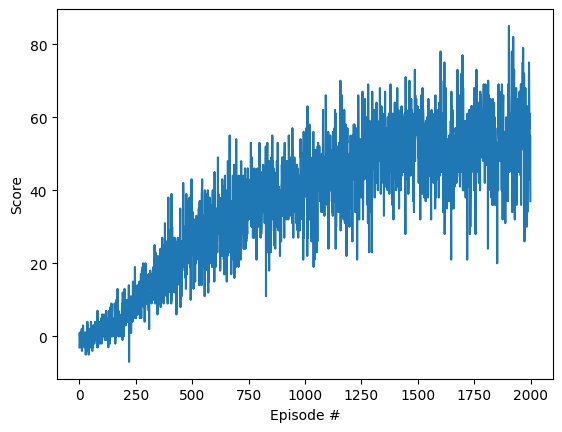

CPU times: user 4h 22min 6s, sys: 22min 50s, total: 4h 44min 57s
Wall time: 12h 3min 18s


In [24]:
%%time

results = list()

def dqn(sensor_id=2, n_episodes=2000, max_t=1500, eps_start=1.0, eps_end=0.01, eps_decay=0.995, print_every=100, save_every=None):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    global results
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=print_every)  # last "print_every" scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        results = list(agent_gen(learn=True, n=max_t, eps=eps, sensor_id=sensor_id))
        score = results[-1][2]
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if save_every is not None:
            if i_episode % save_every == 0:
                save_trained_nn(agent.qnetwork_local, scores=scores, episode=i_episode, export_onnx=False)
        if np.mean(scores_window)>=100.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-print_every, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

# sensor_id 0: Camera Sensor, 1: Grid Sensor, 2: Ray Perception Sensor 3D
if unity_sensor_id == 2:
    scores = dqn(n_episodes=2000, sensor_id=unity_sensor_id, save_every=10)
if unity_sensor_id == 0:
    BUFFER_SIZE = int(2e5)  # replay buffer size
    BATCH_SIZE = 128        # minibatch size
    GAMMA = 0.995           # discount factor
    TAU = 1.25e-3           # for soft update of target parameters
    LR = 8e-4               # learning rate: 8e-4 worked
    UPDATE_EVERY = 10       # how often to update the network
    scores = dqn(n_episodes=2000, sensor_id=unity_sensor_id, save_every=10,  eps_decay=0.9973)

trained = True
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# Try continuing the training...
# more_scores = dqn(n_episodes=5, eps_start=0.02, sensor_id=unity_sensor_id, eps_decay=0.997)

In [ ]:
%%capture
game_clip_training = make_game_clip(frames=results[0:200], scale_adjustment=1.25).to_html5_video()

In [ ]:
HTML(game_clip_training)

Finally save the trained model parameters or load the parameters of a previously trained model for further analysis or application.

In [25]:
# Save model. WARNING: An existing model will be overwritten
if trained:
    save_trained_nn(agent.qnetwork_local, scores=scores, results=results, dummy_input=results[0][0][unity_sensor_id])
else:
    print("Didn't save, because the model was not trained yet.")

In [22]:
# Load trained model
if not trained:
    load_trained_nn(agent.qnetwork_local)

## 5. Results

The achieved score after passing x episodes of training for each model is shown in the following picture.

It's not a surprise that the **best score** is achieved when using the ***Ray Perception Sensor*** with the simple **QNetwork_FC1**. The Agent learns fast and is definitely demonstrating a "better than human" performance.

When using the ***Camera Sensor*** with a low resolution of 40x40 RGB, the training just works with `QConvNetwork40` and `DQN40_HLC_paper` with a moderate performance given the fact that the image resolution is really poor.

When using the ***Camera Sensor*** with an increased resolution of 64x64 RGB, `DQN64_HLC_paper_Mod1` reaches a better score too. Interestingly there is no learning progress when applying the previously working hyperparameters. So LR (learning rate), GAMMA (discount factor), BUFFER_SIZE and BATCH_SIZE are all increased, to learn faster, longer and from more collected experience.

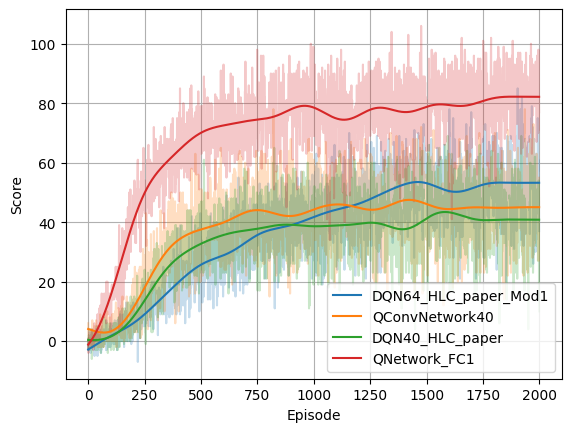

In [81]:
import scipy.signal


def lowpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data


def load_scores(path):
    scores_d = {}
    for filename in os.listdir(path):
        if filename.endswith('.scores.npy'):
            model_name = filename.split('.scores.npy')[0]
            scores_d[model_name] = np.load(os.path.join(path, filename))
    return scores_d


# Load the scores
scores_d = load_scores('saved_models')


fig = plt.figure()
ax = fig.add_subplot(111)

sample_rate = 1.0
times = np.arange(len(scores))/sample_rate
line_list = []

for k in scores_d.keys():
    scores = scores_d[k]
    ax.plot(np.arange(len(scores)), scores, alpha=0.25)
    line_list.append((k, ax.get_lines()[-1].get_color()))

for k, c in line_list:
    scores = scores_d[k]
    filtered = lowpass(scores, 0.004, sample_rate)
    ax.plot(np.arange(len(filtered)), filtered, color=c, label=k)

ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.legend()
ax.grid()

Results from more model architectures and more enhanced Deep-Q Learning algorithms might be added here :-)

## 6. Watching the Agent
Simply watching the Agent to play provides a good impression whether the learnt policy is good or bad.

In [32]:
%%time
#%%capture
# The "trained Agent" runs for n steps
results_trained = list(agent_gen(n=100, sensor_id=unity_sensor_id))

CPU times: user 422 ms, sys: 43.6 ms, total: 465 ms
Wall time: 1.51 s


### 6.1 Using the Ray Perception Sensor
The trained Agent using the ***Ray Perception Sensor 3D*** show a very smooth looking and successful behavior.

In [33]:
%%capture
if unity_sensor_id == 2:
    game_clip3 = make_agent_clip(results_trained, normalize=True).to_html5_video()

    # https://stackoverflow.com/questions/55163024/how-to-convert-matplotlib-animation-to-an-html5-video-tag
    with open("game_clip3.html", "w") as f:
        print(game_clip3, file=f)

In [34]:
HTML(game_clip3)

Note: A visualization of the Ray Perception Sensor would be certainly interesting here. There is a snippet in the bottom of this notebook were this was started implementing. This requires knowledge on how the features are aligned in the observation vector. However, for the training, the model doesn't care...

In [37]:
with open(os.path.join('saved_models', 'QNetwork_FC1_Final.results.pickle.dump'), 'wb') as pickle_dump_file:
    pickle.dump(results_trained, pickle_dump_file)

### 6.2 Using the Camera Sensor
The visual behavior of the Agent using the ***Camera Sensor*** only looks very good as well. Probably a little bit less smooth. Of course it less successfull by score. When watching it for longer, it sometimes looks a little bit "clumsy". E.g. it sometimes misses a marble when approaching it after a turn. It seems that it acts just directly based on the actual visual perception and it didn't learn the concept inertia. This could be addressed if the Unity scene would provide more temporal information through stacked images or using the Agent's actual velocity features (see the function `CollectObservations` in the script `foodCollectorAgent.cs`).

In [27]:
%%time
%%capture
if unity_sensor_id == 0:
    game_clip4 = make_agent_clip(results_trained, normalize=True).to_html5_video()

CPU times: user 58.3 s, sys: 4.04 s, total: 1min 2s
Wall time: 1min 5s


In [28]:
HTML(game_clip4)

The application the learnt kernels of the first convolutional layer provides an impression which features are probably extracted there. So its probably either walls, marbles, marbles by color, marbles by distance and so on...

In [31]:
%%time
%%capture
if unity_sensor_id == 0:
    weigths_conv1 = agent.qnetwork_local.conv1.weight.data.cpu().clone().numpy()
    game_clip5 = make_agent_clip(results_trained, weigths_conv1, normalize=True).to_html5_video()

CPU times: user 11min 33s, sys: 1min 15s, total: 12min 48s
Wall time: 13min 22s


In [32]:
HTML(game_clip5)

In [33]:
# https://stackoverflow.com/questions/55163024/how-to-convert-matplotlib-animation-to-an-html5-video-tag
with open("game_clip4.html", "w") as f:
    print(game_clip4, file=f)

with open("game_clip5.html", "w") as f:
    print(game_clip5, file=f)

In [ ]:
%%capture
fig = plt.figure(figsize=(9,4))
weigths_conv1 = agent.qnetwork_local.conv1.weight.data.cpu().clone().numpy()
# filtered_images_cv = apply_kernels_to_image(results[25][0][0], weigths_conv1)
visualize_output_func(fig, weigths_conv1)(results[9])

### 6.3 Using the Camera Sensor and odometric feedback
This section is a placeholder for an Agent that additionally uses the speed feedback (x and y) from the Unity environment.

## Misc & Sandbox
Some snippets for later usage are left here...

In [ ]:
# Visualization of the Ray Perception Sensor 3D
import matplotlib.pyplot as plt
import numpy as np

ray_length = 30
rays_per_direction = 6
max_ray_degrees = 60

# Fixing random state for reproducibility
np.random.seed(19680801)

# Compute pie slices
N = 2*rays_per_direction+1
theta = np.linspace(0.0, max_ray_degrees/180 * 2 * np.pi, N, endpoint=False) -  max_ray_degrees / 180 * np.pi
radii = 10 * np.random.rand(N)
width = 0.1*np.pi / 4 # TODO: Change width corresponding to the "Sphere Cast Radius" and the radii (distance)
colors = plt.cm.viridis(radii / 10.)

ax = plt.subplot(projection='polar')
# ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)
ax.bar(theta, radii, width=width, bottom=0.0, color='orange', alpha=0.5)

plt.show()

In [ ]:
import netron

In [ ]:
netron.start(file='saved_models/QConvNetwork40.onnx')

In [ ]:
netron.start(file='GridFoodCollector2.onnx')

In [ ]:
env.close()